In [71]:
import pandas as pd
file = "un-general-debates-blueprint.csv"
df = pd.read_csv(file)
df.head(20)

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."
5,25,1970,BLR,Belarus,Mr. GURINOVICH,NaN,\n71.\t. We are today mourning the untimely de...
6,25,1970,BOL,"Bolivia, Plurinational State of",Mr. CAMACHO OMISTE,NaN,135.\t I wish to congratulate the President o...
7,25,1970,BRA,Brazil,Mr. GIBSON BARBOZA,NaN,"1.\tMr. President, I should like, first of all..."
8,25,1970,CAN,Canada,Mr. SHARP,NaN,\nThe General Assembly is fortunate indeed to ...
9,25,1970,CMR,Cameroon,Mr. AHIDJO,President,: A year ago I came here as the Acting Preside...


#Getting the StopWords

In [72]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print(stopwords)

{'theirs', "wasn't", 'so', 'him', 'from', 'both', "doesn't", 'there', 'why', 're', 'didn', 'up', 'haven', 'hadn', "mightn't", 'her', 'how', 'they', 'himself', 'weren', 'few', 'a', 'yours', "couldn't", 'after', "she's", 'are', 'if', 'these', 'on', 'same', 'his', 'too', 'can', 't', 'do', "you'll", 'through', 'between', 'then', 'to', 'nor', 'ma', 'before', 'in', 'now', 'doesn', 'down', "haven't", 'very', "needn't", 'ain', 'herself', 'than', 'while', 'isn', 'again', "won't", 'those', "you're", 'own', 'or', 'o', 'he', 'yourselves', 'my', 'what', 'all', 'with', 'itself', 'did', 'mustn', 'wasn', 'your', 'here', 'above', 'd', 'which', 'had', 'about', "mustn't", 'being', "shouldn't", 'needn', "it's", "hasn't", 'i', 'the', 'for', 'be', 'most', 'doing', 'against', 'has', 'each', 'couldn', 'you', "don't", 'where', 'was', 'under', 'because', 'other', 'more', 's', 'been', 'll', 'who', "hadn't", 'y', 'an', 'myself', 'no', 'mightn', "wouldn't", 'hers', 'shouldn', 'some', 'just', 'into', 'we', "that'll

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gragh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Pre-processing pipeline

In [73]:
import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*[a-z|A-Z][\w-]*', text)
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for fun in pipeline:
        tokens = fun(tokens)
    return tokens
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

#count the tokens

In [74]:
from collections import Counter
counter = Counter()
df['tokens'].map(counter.update)
freq_df = pd.DataFrame.from_dict(counter, orient='index',columns=['freq'])
freq_df = freq_df.query('freq >= 1')
freq_df.index.name = 'tokens'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(10)

,freq
tokens,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


#WordCloud

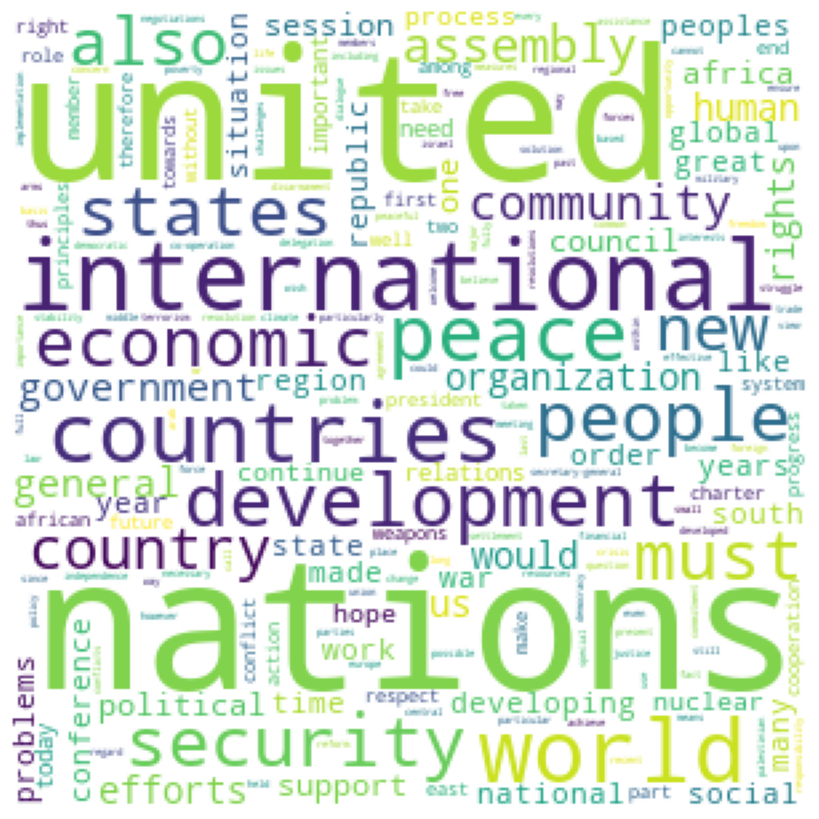

In [75]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
wc = WordCloud(background_color='white', width = 300, height=300, margin=2)
wc.fit_words(freq_df['freq'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)

#TFIDF and Compare

In [76]:
import numpy as np
def compute_idf(df, column='tokens', preprocess=None, min_df=1):
 def update(doc):
   tokens = doc if preprocess is None else preprocess(doc)
   counter.update(set(tokens))
 # count tokens
 counter = Counter()
 df[column].map(update)
 # create data frame and compute idf
 idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
 idf_df = idf_df.query('df >= @min_df')
 idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
 idf_df.index.name = 'token'
 return idf_df
idf_df = compute_idf(df)

TFIDF = TF * IDF

In [77]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
freq_df.head()

,freq,tfidf
tokens,,
nations,124508,12649.986284
united,120763,12285.608632
international,117223,12364.276226
world,89421,9503.708982
countries,85734,10888.485986


#WordCloud

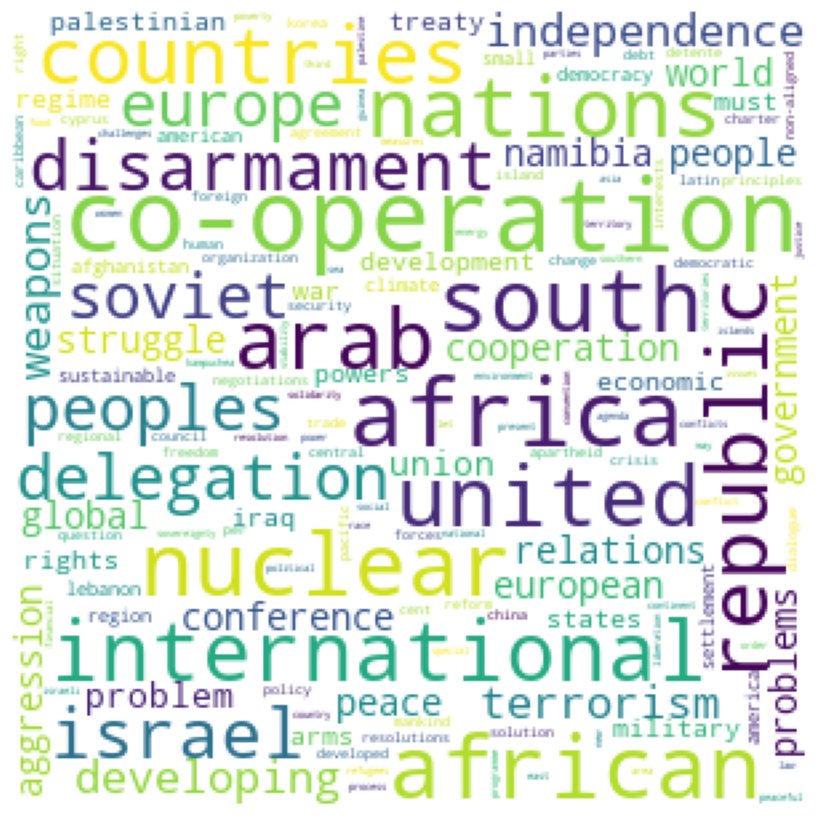

In [78]:
wc = WordCloud(background_color='white', width = 300, height=300,margin=2)
wc.fit_words(freq_df['tfidf'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#1970

#Function to count the keywords

In [79]:


# Assuming df['tokens'] contains a list of tokens for each entry in your DataFrame

df['num_tokens'] = df['tokens'].map(len)

def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

# Example usage:
# Assuming 'tokens' is a list of tokens for each entry in your DataFrame, and 'keywords' is a list of keywords
# df['keyword_counts'] = df['tokens'].apply(lambda x: count_keywords(x, keywords))


In [80]:
def count_keywords_by(df, by, keywords, column='tokens'):
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps inthe index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix,columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    return freq_df.groupby(by=by).sum().sort_values(by)

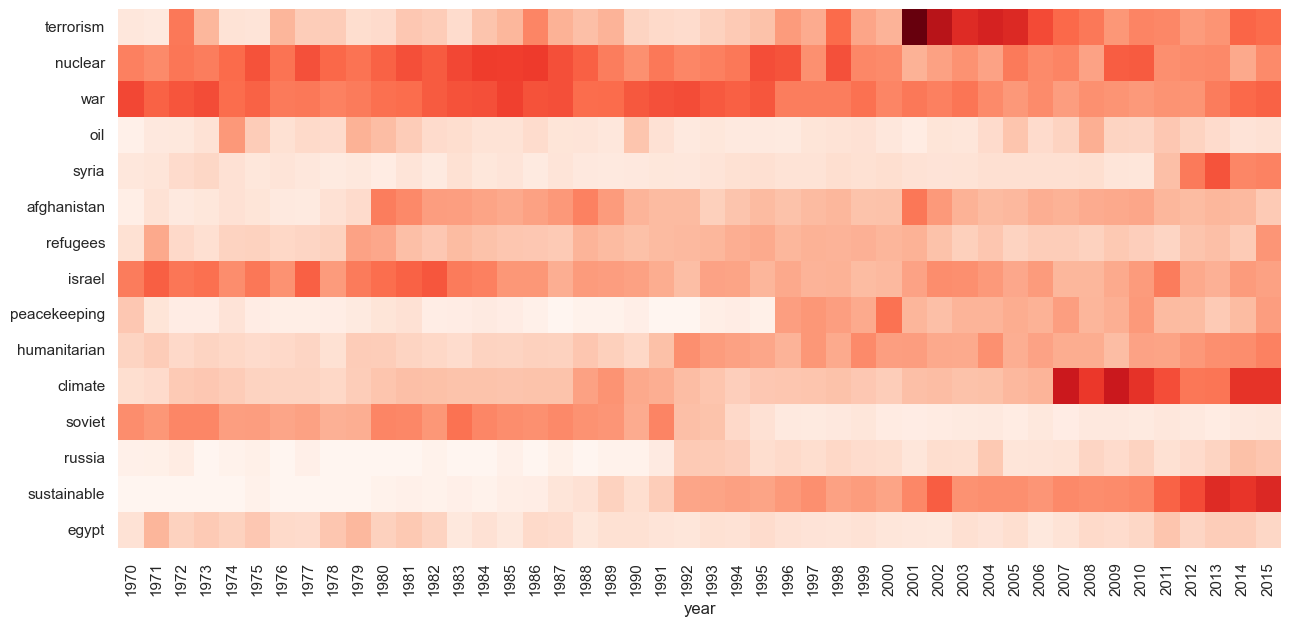

In [81]:
keywords = ['terrorism', 'nuclear', 'war', 'oil','syria', 'afghanistan', 'refugees', 'israel', 'peacekeeping','humanitarian', 'climate', 'soviet','russia', 'sustainable','egypt']
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
freq_df = freq_df.apply(np.sqrt)
# Plotting the heatmap
plt.figure(figsize=(15, 7))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T,xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1)